In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os

import shutil
import argparse

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_files_from_folder(path):

    files = os.listdir(path)
    return np.asarray(files)

def cat_data(path_to_test, path_to_train):
    _, dirs, _ = next(os.walk(path_to_test))
    
    data_counter = np.zeros((len(dirs)))
    for i in range(len(dirs)):
        path = os.path.join(path_to_test, dirs[i])    
        files = get_files_from_folder(path)
        data_counter[i] = len(files)
        
    for i in range(len(dirs)):
        path_to_original = os.path.join(path_to_test, dirs[i])
        path_to_save = os.path.join(path_to_train, dirs[i])
        
        files = get_files_from_folder(path_to_original)
    
        for j in range(int(data_counter[i])):
            dst = os.path.join(path_to_save, files[j])
            src = os.path.join(path_to_original, files[j])
            shutil.move(src, dst)
        
        os.rmdir(path_to_original)
    os.rmdir(path_to_test)

def split_data(path_to_data, path_to_test_data, train_ratio):
    # get dirs
    _, dirs, _ = next(os.walk(path_to_data))

    # calculates how many train data per class
    data_counter_per_class = np.zeros((len(dirs)))
    for i in range(len(dirs)):
        path = os.path.join(path_to_data, dirs[i])
        files = get_files_from_folder(path)
        data_counter_per_class[i] = len(files)
    test_counter = np.round(data_counter_per_class * (1 - train_ratio))

    # transfers files
    for i in range(len(dirs)):
        path_to_original = os.path.join(path_to_data, dirs[i])
        path_to_save = os.path.join(path_to_test_data, dirs[i])

        #creates dir
        if not os.path.exists(path_to_save):
            os.makedirs(path_to_save)
        files = get_files_from_folder(path_to_original)
        # moves data
        for j in range(int(test_counter[i])):
            dst = os.path.join(path_to_save, files[j])
            src = os.path.join(path_to_original, files[j])
            shutil.move(src, dst)

In [4]:
cat_data('fruits/test', 'fruits/train')

In [4]:
split_data('fruits/train', 'fruits/test', 0.8)

In [5]:
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)

Using cache found in /home/waving666/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ssd_model.to(device)
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [7]:
data_transforms = {
    'train':
        transforms.Compose([
            transforms.Resize((300,300)),
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])]),
    'test':
        transforms.Compose([
            transforms.Resize((300,300)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])}

image_datasets = {
    'train':
        datasets.ImageFolder('fruits/train', data_transforms['train']),
    'test':
        datasets.ImageFolder('fruits/test', data_transforms['test'])}

dataloaders = {
    'train':
        DataLoader(
            image_datasets['train'],
            batch_size=32,
            shuffle=True,
            num_workers=4),
    'test':
        DataLoader(
            image_datasets['test'],
            batch_size=32,
            shuffle=False,
            num_workers=4)}

class_names = image_datasets['train'].class_to_idx

In [33]:
images, labels = next(iter(dataloaders['train']))
type(images)

torch.Tensor

In [34]:
images.shape

torch.Size([32, 3, 300, 300])

In [35]:
class_names

{'Apple': 0,
 'Banana': 1,
 'Carambola': 2,
 'Guava': 3,
 'Kiwi': 4,
 'Mango': 5,
 'Muskmelon': 6,
 'Orange': 7,
 'Peach': 8,
 'Pear': 9,
 'Persimmon': 10,
 'Pitaya': 11,
 'Plum': 12,
 'Pomegranate': 13,
 'Tomatoes': 14}

In [36]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

Using cache found in /home/waving666/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [37]:
with torch.no_grad():
    detections_batch = ssd_model(images.to(device))

In [41]:
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.50) for results in results_per_input]

In [42]:
classes_to_labels = utils.get_coco_object_dictionary()

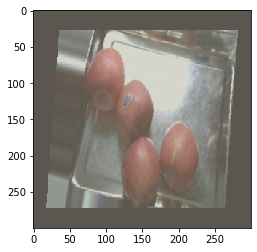

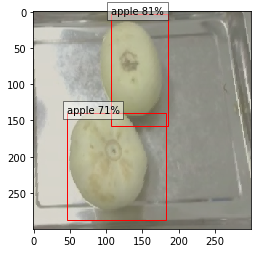

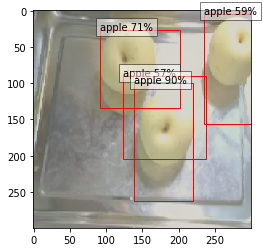

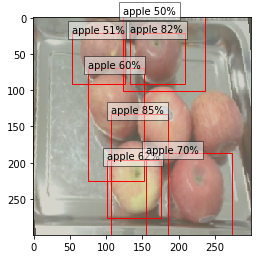

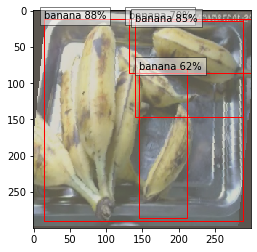

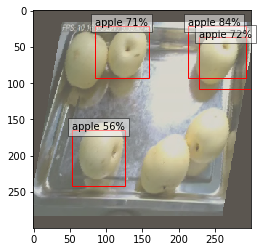

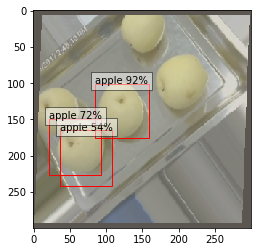

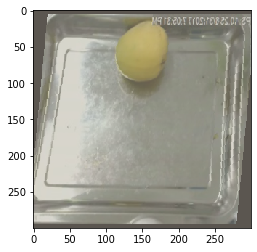

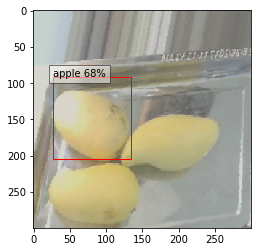

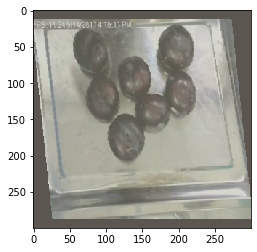

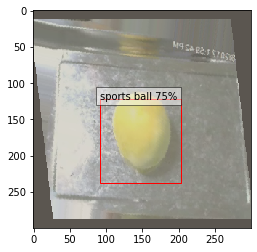

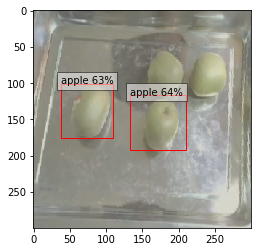

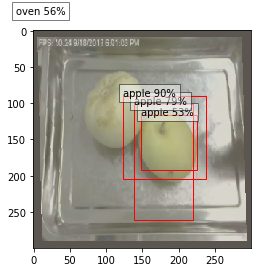

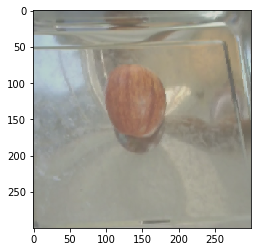

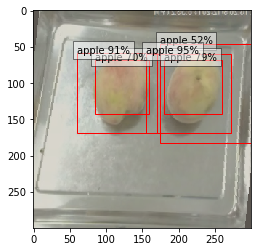

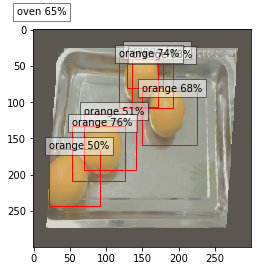

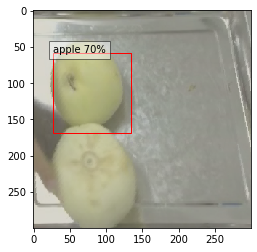

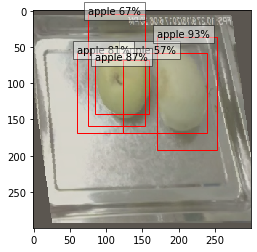

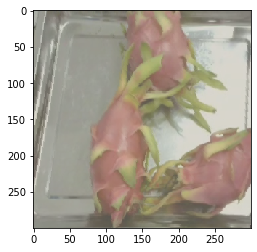

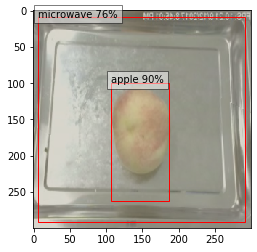

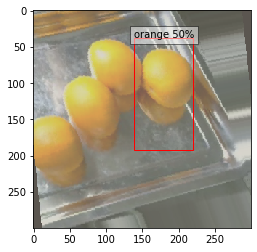

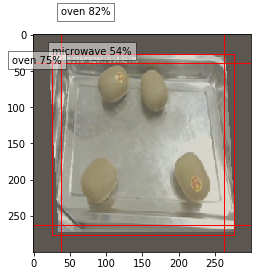

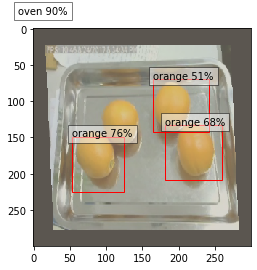

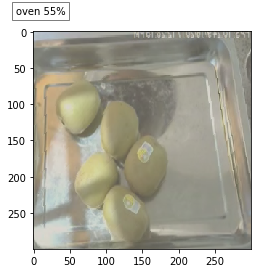

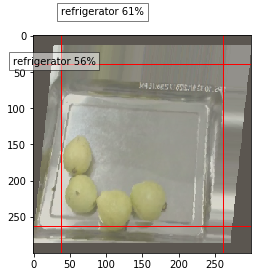

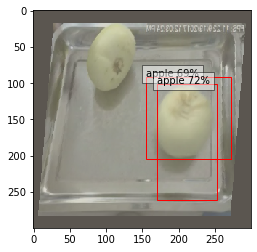

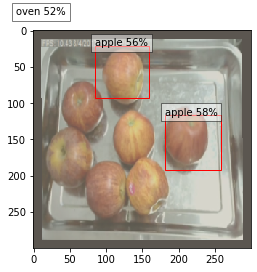

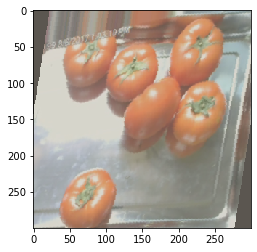

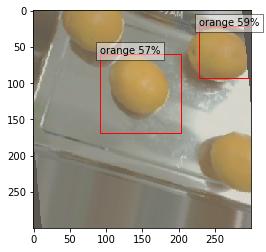

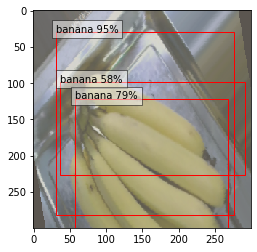

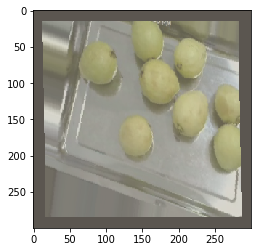

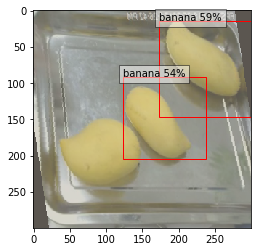

In [43]:
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = images[image_idx] / 2 + 0.5
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    image = inv_normalize(image)
    ax.imshow(np.transpose(image.numpy(),(1,2,0)))
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()